<div style="background-color:#009440; padding: 0px; background-size:cover; background-opacity:50%; border-radius:5px; height:300px">
    <div style="margin: 5px; padding: 10px;">
    <h1 style="color:#00000">Geophysical Data Acquisition and Analysis</h1>
    <h4 style="color:#dddddd">LMU, 08 August 2019</h4>
        <h4 style="color:#dddddd">Authors: Ceri Nunn, Stefanie Donner, Alice Gabriel, Céline Hadziioannou, Stephanie Wollherr, Taufiqurrahman</h4>
    </div>
    <div style="float:right; margin: 10px; padding: 20px; background:rgba(255,255,255,0.7); width: 70%; height: 150px">
        <div style="position:relative; top:30%; transform: translateY(-50%)">
        <div style="font-size: x-large; font-weight:900; color:rgba(0,0,0,0.8); line-height:100%">P10 - Correlations</div>
        </div>
    </div>
   
</div>

**Please, do not forget to execute Cell 1 first!**

In [1]:
# Cell 1: Preparation for programming
import warnings
warnings.filterwarnings("ignore")
%matplotlib notebook
from scipy import interpolate, signal
from time import *
from obspy import *
from obspy.core import read, UTCDateTime
from obspy.clients.fdsn import Client
import numpy as np
import matplotlib.pylab as plt
import os
import glob
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['lines.linewidth'] = 1

We begin with the discrete form of the cross covariance function: 

$$\large{(f \star g) [n] \overset{\mathrm{def}}{=} \sum_{m=-\infty}^{\infty} f^*\ [m]\ g[m + n]}$$

We start with a simple example: 

$$f = [0,1,2,1,0,0,0]$$
$$g = [0,2,4,2,0,0,0]$$

We can calculate the cross-covariance function (without shifting the signals): 

$$corr(f,g) = 0 * 0\ +\ 1 * 2\ +\ 2 * 4\ +\ 1 * 2\ +\ 0 * 0\ +\ 0 * 0\ +\ 0 * 0$$

$$=12$$

In many cases, it is helpful to normalize the cross-covariance function. 



## Exercise 1

We are going to use the numpy package to check the calculation above. 

**1a)** Read the explanation above, as well as the code below, and check that you understand it. 

**1b)** Experiment with the parameter 'mode'. The options are 'full, 'valid' and 'same'. Read the documenation! What does the parameter do? What affect does it have on the length of the output signal. 



### Answer: ...

Simple correlation function: 
[ 0  2  8 12  8  2  0]


<IPython.core.display.Javascript object>


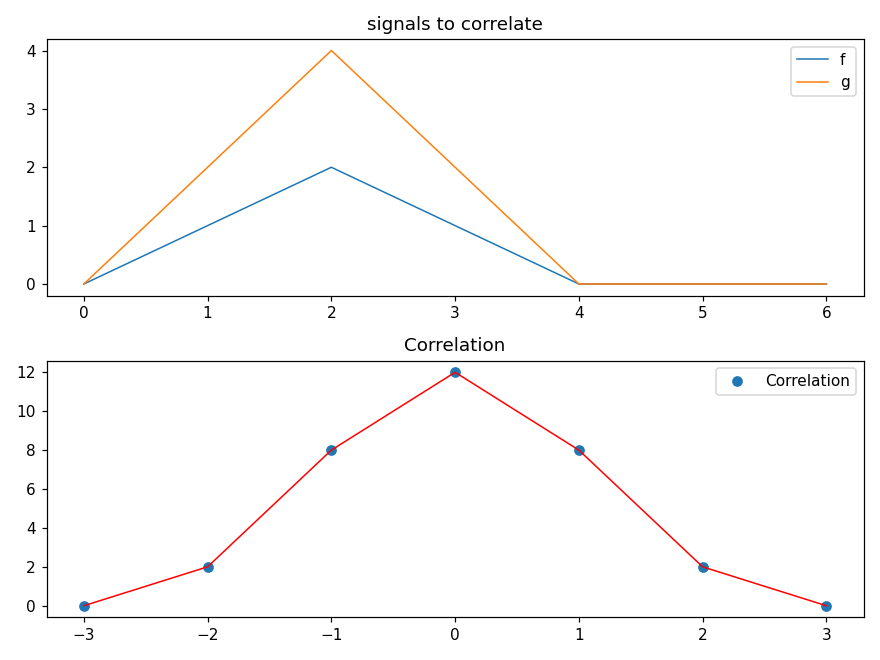

In [4]:
# Cell 1a

plt.ioff()
# the signals to cross-correlate
f = [0,1,2,1,0,0,0]
g = [0,2,4,2,0,0,0]

# calculate the correlation
xcorr1 = np.correlate(f,g,mode='same')
# Is the cross correlation the same value that we have already calculated? 

print("Simple correlation function: ")
print(xcorr1)
dt = 1

# make array with time shifts in seconds corresponding to cc function
# note that bound and cc_t both depend on the length and mode of the 
# cross correlation function
bound = ((len(xcorr1)-1)*dt)/2 
cc_t = np.linspace(-bound, bound, len(xcorr1))

plt.subplot(2,1,1)
plt.title('signals to correlate')
plt.plot(f, label='f')
plt.plot(g, label='g')
plt.legend()

# Note, that with this short example, the correlation plot only works in 'same' or 'full' mode.
plt.subplot(2,1,2)
plt.title('Correlation')
plt.plot(cc_t, xcorr1, 'o', label='Correlation')
plt.plot(cc_t, xcorr1,'r')
plt.legend()
plt.tight_layout()
plt.show()

## Exercise 2 - correlating simple signals
This exercise will show you how you can determine the lag between two signals with the correlation. You will also see what can happen when you correlate noisy signals. 

Have a look at the code. It generates a Ricker wavelet (rk) and shifts it by a certain lag to create the second signal (rk2). On a shifted signal, there is the option to add random noise (rkn). 
The correlation function between both signals is calculated and shown in the plot. 


**2a)** Explain the meaning of the red line on the correlation function plot. Why does the time axis run from -100 to 100 seconds? Can you use the correlation function to determine the lag between the two signals? Use the option to zoom in (with xlim, see code) if needed. Does this lag value match the real lag? 

**2b)** Increase the noiselevel. Try some values between 0.1 and 1. Describe what you see happening to the signals, and to the correlation function. Can the lag between the signals still be determined? What happens to the correlation coefficient? What does this mean?

**2c)** In the line where the correlation function of rk and rk2 is calculated: change the order of 'rk' and 'rk2'. What happens to the output? Which property of the correlation does this illustrate? 

*Write your answers in the markup cell below the plots!*

<IPython.core.display.Javascript object>


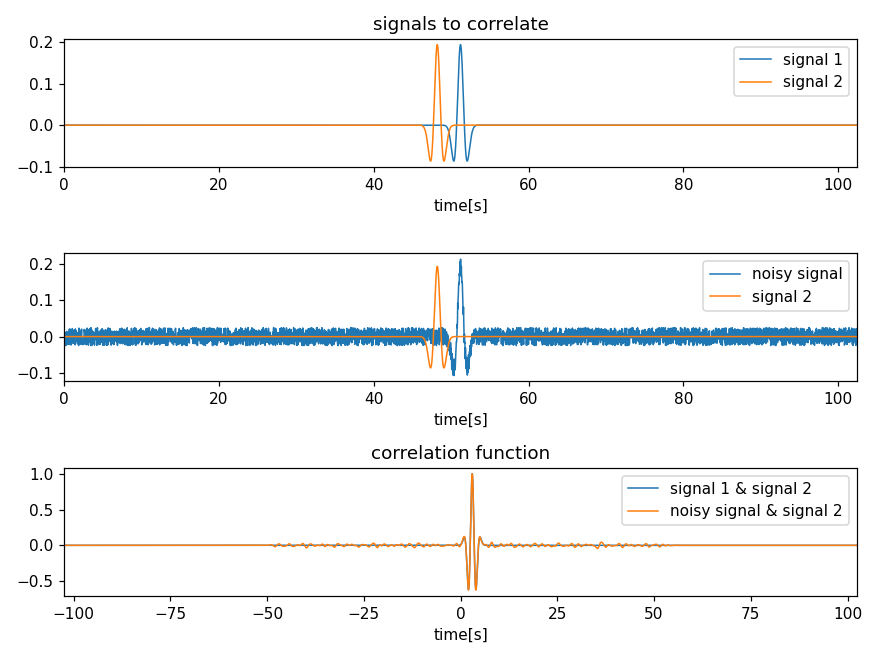

shift between signal 1 and signal 2: 3.000000 seconds 
 
shift between noisy signal and signal 2: 3.000000 seconds
correlation coefficient between noisy signal and signal 2:  0.735199048072


In [18]:
# Cell 2a:

plt.ioff()
lag = 3       # lag in seconds, initial value 3
noiselevel = 0.05  # noise level to add, initial value 0.1

# create time vector
npts = 4096     # number of samples, initial value: 4096
dt = 0.025      # sample rate, initial value:0.025 
t = np.linspace(0,(npts-1)*dt,npts)

# create original signal: Ricker wavelet
rk = signal.ricker(npts, 20.0)         # 2nd number = width of wavelet, intial value: 20.0 
# create shifted signal
rk2 = np.zeros(rk.size)
#rk2[int(lag/dt):] = rk[:int(-lag/dt)]
rk2 = np.roll(rk,int(-lag/dt))

# create a noisy signal
rkn = rk  + noiselevel * np.random.rand(rk.size) 
rkn -= rkn.mean()

# calculate the correlation function between signal 1 and signal 2
xcorr1 = np.correlate(rk, rk2, mode='full')

# make array with time shifts in seconds corresponding to cc function
# note that bound and cc_t both depend on the length and hence the 
# mode of the cross correlation function
bound = ((len(xcorr1)-1)*dt)/2 
cc_t = np.linspace(-bound, bound, len(xcorr1))

# extract the maximum value from the correlation function
peak_index = abs(xcorr1).argmax()

# calculate the correlation function between noisy signal and signal 2
xcorrn = np.correlate(rkn, rk2, mode='full')
# extract the location of the maximum value from the correlation function
peak_index_n = abs(xcorrn).argmax()
norm = (np.sum(rkn**2)*np.sum(rk**2))**0.5
corrcoef = xcorrn[peak_index_n]/norm

plt.subplot(3,1,1)
plt.title('signals to correlate')
plt.plot(t,rk, label='signal 1')
plt.plot(t,rk2, label='signal 2')
plt.xlabel('time[s]')
plt.xlim((0, npts*dt))
plt.legend()

plt.subplot(3,1,2)
plt.plot(t,rkn, label='noisy signal')
plt.plot(t,rk2, label='signal 2')
plt.xlim((0, npts*dt))
plt.xlabel('time[s]')
plt.legend()

plt.subplot(3,1,3)
plt.title('correlation function')
plt.plot(cc_t, xcorr1, label='signal 1 & signal 2')
plt.plot(cc_t, xcorrn, label='noisy signal & signal 2')
plt.legend()
plt.xlabel('time[s]')
plt.xlim((-npts*dt, npts*dt))
# uncomment the following line to zoom in 
# plt.xlim((-10,10))
plt.xlabel('time[s]')

# prevent subplots overlapping
plt.tight_layout() 
plt.show()

print("shift between signal 1 and signal 2: %f seconds \n " % cc_t[peak_index])
print("shift between noisy signal and signal 2: %f seconds" % cc_t[peak_index_n])
print("correlation coefficient between noisy signal and signal 2: ", corrcoef)

### Answer: ...


## Exercise 2, continued
Here, you will use signals from an earthquake, measured at two different locations. 

**2d)** Try to determine the lag between signal 1 and signal 2 from the seismogram signals (first plot). Zoom in using the 'xlim' line and adjust the limits if necessary. Do the same using the correlation signal in the second plot. What values to you find? Does this correspond to the value determined by the code by finding the maximum of the correlation? 

**2e)** Answer the question **2d)** for signal 2 and signal 3. What do you notice about the correlation coefficient? What does this mean? Set the noise level to zero, then also incrementally increase the noise level. What happens to the correlation coefficient?

**2f)** Given that this is the same earthquake measured at two different seismometers. If you know the location of the seismometers, what could you use the lag time you determined for? 

*Write your answers in the markup cell below the plots!*

1 Trace(s) in Stream:
BW.UH1..EHZ | 2010-05-27T16:24:32.815000Z - 2010-05-27T16:24:33.815000Z | 200.0 Hz, 201 samples 
 1 Trace(s) in Stream:
BW.UH1..EHZ | 2010-05-27T16:27:30.085000Z - 2010-05-27T16:27:31.085000Z | 200.0 Hz, 201 samples 
 1 Trace(s) in Stream:
BW.UH1..EHZ | 2010-05-27T16:27:30.085000Z - 2010-05-27T16:27:31.085000Z | 200.0 Hz, 201 samples


<IPython.core.display.Javascript object>


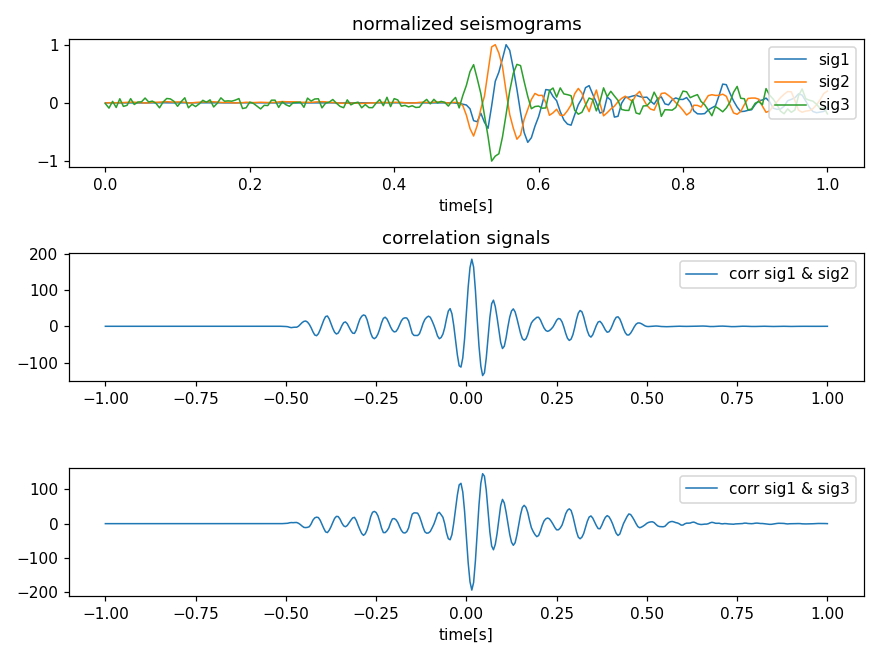

shift between signal 1 and signal 2: 0.015000 seconds
correlation coefficient between signal 1 and signal 2: 0.919198 

shift between noisy signal and signal 2: 0.015000 seconds
correlation coefficient between noisy signal and signal 2: -0.885263


In [22]:
# Cell 2b: 
## using example data of two small earthquakes

plt.ioff()
st1 = read('DATA/seismogram1.sac')
st2 = read('DATA/seismogram2.sac')
st3 = st2.copy()

#select the vertical component of the seismogram
tr1 = st1.select(component="Z")[0]
tr2 = st2.select(component="Z")[0]
tr3 = tr2.copy()



dt = tr1.stats.delta

#divide by standard deviation
tr1.data = tr1.data/tr1.std()
tr2.data = tr2.data/tr2.std()
tr3.data = tr3.data/tr3.std()

# add random noise to signal:
noiselevel = 0.2 # initial value 0.2 
tr3.data = tr3.data * -1.0 + noiselevel * tr3.max() * np.random.rand(tr3.data.size) 
tr3.detrend('linear')

print(st1, '\n', st2, '\n', st3)

# calculate cross-correlation, lag and correlation coefficient
xcorr1 = np.correlate(tr1.data, tr2.data, mode='full')
peak_index1 = abs(xcorr1).argmax()

cc1 = np.corrcoef(tr1.data, tr2.data)[0,0]
norm = (np.sum(tr1.data**2)*np.sum(tr2.data**2))**0.5
cc1 = xcorr1[peak_index1]/norm

xcorr2 = np.correlate(tr1.data, tr3.data, mode='full')
peak_index2 = abs(xcorr2).argmax()
norm = (np.sum(tr1.data**2)*np.sum(tr3.data**2))**0.5
cc2 = xcorr2[peak_index2]/norm

# make array with time shifts in seconds corresponding to cc function
# note that bound and cc_t both depend on the length and mode of the 
# cross correlation function
bound = ((len(xcorr1)-1)*dt)/2 
cc_t = np.linspace(-bound, bound, len(xcorr1))

plt.subplot(3,1,1)
plt.title('normalized seismograms')
plt.plot(tr1.times(), tr1.data/abs(tr1.max()), label='sig1')
plt.plot(tr2.times(), tr2.data/abs(tr2.max()), label='sig2')
plt.plot(tr3.times(), tr3.data/abs(tr3.max()), label='sig3')
plt.legend()
# uncomment the following line to zoom in to the first plot if needed
#plt.xlim((0.5, 0.6))
plt.xlabel('time[s]')

plt.subplot(3,1,2)
plt.title('correlation signals')
plt.plot(cc_t, xcorr1, label='corr sig1 & sig2')
# uncomment the following line to zoom in to the first plot if needed
#plt.xlim((0.01, 0.02))
plt.legend()
plt.subplot(3,1,3)
plt.plot(cc_t, xcorr2, label='corr sig1 & sig3')
# uncomment the following line to zoom in to the first plot if needed
#plt.xlim((0.1, 0.2))
plt.legend()
plt.xlabel('time[s]')

plt.tight_layout() 
plt.show()

print("shift between signal 1 and signal 2: %f seconds" % cc_t[peak_index1])
print("correlation coefficient between signal 1 and signal 2: %f \n" % cc1)

print("shift between noisy signal and signal 2: %f seconds" % cc_t[peak_index2])
print("correlation coefficient between noisy signal and signal 2: %f"% cc2)

**Answer: ...**

## Exercise 3: Backazimuth of an earthquake

In this exercise you will see an application of the correlation. 

If you measure the transverse acceleration (using a "traditional" seismometer) and the rotation rate (using for example a ring laser) at the same location, the waveforms should be the same. This only holds if the horizontal components (N, E) of the seismometer record are oriented to point towards the earthquake source location: towards "radial" (R, pointing to source) and "transverse" (T, perpendicular to the great circle path connecting source and receiver). 

If you don't know where the source was, you can exploit this property by using the correlation coefficient. In this exercise, a seismogram is cut into smaller time windows. For each time window, the two horizontal components (N, E) are oriented towards different backazimuth angles from 0-360, giving us R, T components for each angle. 

For each angle between 0-360, the waveform of the transverse (T) component is compared to the waveform for rotation. If the waveforms match, you know you have the correct angle and are pointing towards the source. 

**3a)** Can you explain why the correlation coeffcient is used for this?

In Cell 3a, there is the option to download signals for four different events. Choose one of events 1-3 (uncomment the corresponding 't1' and 't2') and run cell 3a. The processing described above is performed in cell 3b, and cell 3c plots the results.  

**3b)** In the second plot, red colors indicate good positive correlation (up to 1), grey stands for negative correlation (down to -1). Can you say towards which backazimuth the earthquake occurred? Why are the grey colors always separated by 180 degrees from the red colors? 

**3c)** Choose event 4 and run Cells 3a-3c. What does the backazimuth plot look like? Now set the bandpass filter to filter between 0.1 and 0.2 Hz. Re-run Cells 3a, 3b and 3c. What has changed? How do you explain this? 

*Write your answers in the markup cell below the plots!*

3 Trace(s) in Stream:
GR.WET..BHE | 2012-12-27T05:59:59.989999Z - 2012-12-27T08:59:59.989999Z | 20.0 Hz, 216001 samples
GR.WET..BHN | 2012-12-27T05:59:59.989999Z - 2012-12-27T08:59:59.989999Z | 20.0 Hz, 216001 samples
GR.WET..BHZ | 2012-12-27T05:59:59.989999Z - 2012-12-27T08:59:59.989999Z | 20.0 Hz, 216001 samples 
 1 Trace(s) in Stream:
BW.RLAS..BJZ | 2012-12-27T06:00:00.015250Z - 2012-12-27T09:00:00.015250Z | 20.0 Hz, 216001 samples


<IPython.core.display.Javascript object>


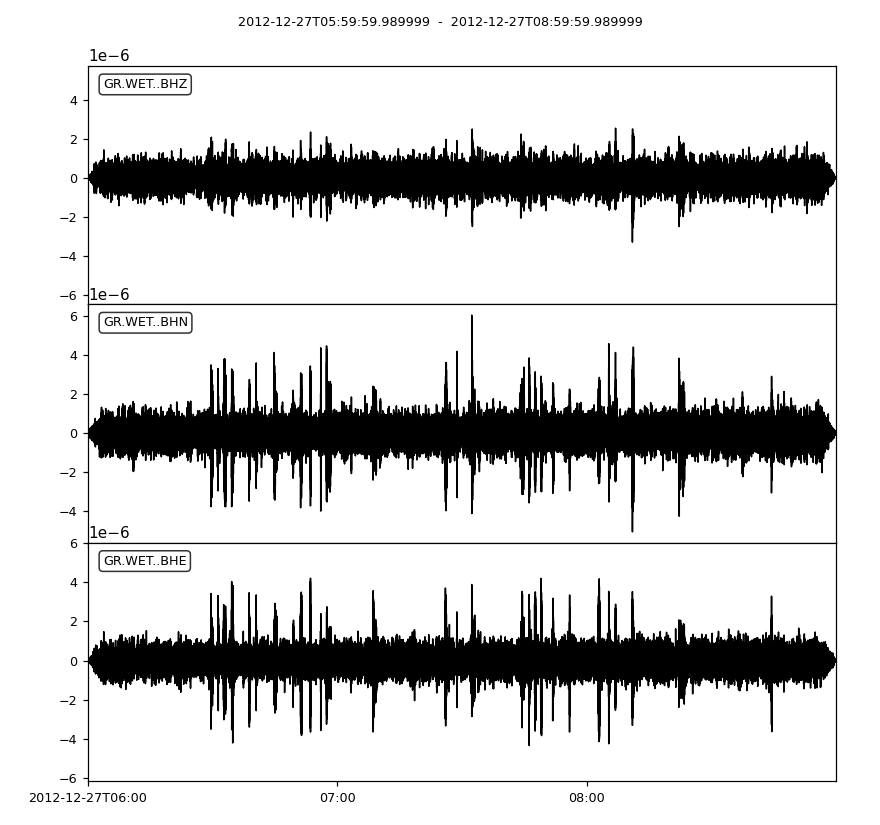

<IPython.core.display.Javascript object>


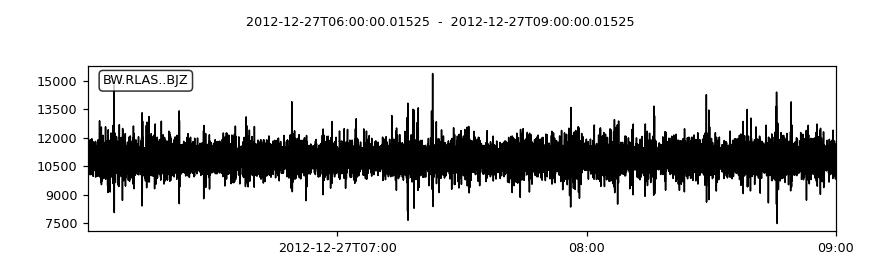

Done


In [29]:
# Cell 3a: 

plt.ioff()
#event 1: M7.0 Kumamoto 2016.04.15
#t1 = UTCDateTime("2016-04-15 16:55:06")
#t2 = UTCDateTime("2016-04-15 17:55:06")

#event 2: M9.0 Tohoku 2011.03.1
#t1 = UTCDateTime("2011-03-11T05:00:00.000")
#t2 = UTCDateTime("2011-03-11T10:00:00.000")

#event 3: M7.9 Nepal 2015.04.25
#t1 = UTCDateTime("2015-04-25T06:08:58.300000")
#t2 = UTCDateTime("2015-04-25T09:11:58.300000")

#event 4: ???? 
t1 = UTCDateTime("2012-12-27T06:00:00.000000")
t2 = UTCDateTime("2012-12-27T09:00:00.000000")


fdsn_client = Client('BGR')
# Fetch waveform from FDSN web service into a ObsPy stream object
# and automatically attach correct response

# broadband seismometer in Wettzell, Germany:
st1 = fdsn_client.get_waveforms(network='GR', station='WET', location='',
                               channel='BH*', starttime=t1, endtime=t2,
                               attach_response=True)
# define a filter band to prevent amplifying noise during the deconvolution
pre_filt = (0.005, 0.006, 30.0, 35.0)
st1.remove_response(output='ACC', pre_filt=pre_filt)

# ring laser rotational instrument in Wettzell, Germany:
fdsn_client = Client('LMU')
st2 = fdsn_client.get_waveforms(network='BW', station='RLAS', location='',
                               channel='BJZ', starttime=t1, endtime=t2,
                               attach_response=True)


# Tohoku event
# if you do not have an internet connection: comment everything above and uncomment the following two lines
#st1 = read('DATA/GR.WET.2011-03-11.mseed')
#st2 = read('DATA/BW.RLAS.2011-03-11.mseed')

print(st1, '\n', st2)
st1.plot()
st2.plot()

print('Done')

In [36]:
#Cell 3b:

plt.ioff()
## bandpass frequencies 
freq_start=0.02      # start of bandpass in Hz, initial value 0.02
freq_end=0.1        # end of bandpass in Hz, initial value 0.1

## backazimuth vector
BAZstep = 10   # BAZ sampling interval in degrees, initial value 10
BAZ = np.linspace(0,360-BAZstep,360//BAZstep)

## sliding timewindow parameters 
startminutes=0      # start first window after [startminutes] 
lwin=200            # window length in seconds
dwin=100       # window shift in seconds; if dwin < lwin : overlapping windows

## prepare signal
st_bb = st1.copy()    # broadband seismometer
st_rl = st2.copy()    # rotational instrument (ring laser)

#trim both to same length
# if this cell is taking much too long, try trimming the signal even shorter (but keep the earthquake!)
st_bb.trim(t1+500, t2-500)
st_rl.trim(t1+500, t2-500)

#bandpass filter
st_rl.filter('bandpass', freqmin=freq_start, freqmax=freq_end)
st_bb.filter('bandpass', freqmin=freq_start, freqmax=freq_end)

fs = st_bb[0].stats.sampling_rate  # sampling frequency
    
## sliding windows in number of samples
startwin=startminutes*fs*60 

lwins=int(lwin*fs)   # window length in samples
dwins=int(dwin*fs)   # window shift in samples
# number of windows: (trace length-startwin-lwin)/lwin
#nwin=(st[0].stats.npts-startwin-lwins)//(lwins+dwins)
nwin=int((st_bb[0].stats.npts-startwin-lwins)//dwins)

## initialize vectors
trans=np.zeros((len(BAZ),int(lwins),int(nwin)))   # vector for rotated transverse acc
corr_zerolag=np.zeros((len(BAZ),nwin))
corr2_zerolag=np.zeros((len(BAZ),nwin),dtype='int32')

imax=np.zeros(nwin,dtype='int32')
cohmax=np.zeros(nwin)


## for each sliding window
for iw in range(nwin):
    
    #rzd = st_rl.select(channel="BJZ")[0].data
    rzd = st_rl.select(channel="BJZ")[0].data

    ted = st_bb.select(channel="BHE")[0].data
    tnd = st_bb.select(channel="BHN")[0].data

    rz1 = rzd[int(startwin+iw*dwins):int(startwin+iw*dwins+lwins)]
    te1 = ted[int(startwin+iw*dwins):int(startwin+iw*dwins+lwins)]
    tn1 = tnd[int(startwin+iw*dwins):int(startwin+iw*dwins+lwins)]
    
    ## for each backazimuth angle: 
    for ia in range(360//BAZstep):
       
        #Compute transversal and radial comp. for all windows, BAZsteps, sample points
        ##  rotate broadband signal to BAZ angle
        
        trans[ia,:,iw] = te1*np.cos((BAZ[ia]+180)*np.pi/180)-tn1*np.sin((BAZ[ia]+180)*np.pi/180)
    
        ## calculate correlation coefficient:
        denom = np.sqrt(np.dot(rz1,rz1)*np.dot(trans[ia,:,iw],trans[ia,:,iw]))
        corr = np.convolve(rz1[::-1],trans[ia,:,iw])/denom

        corr_zerolag[ia,iw] = corr[lwins]   # pick value at center

    ## maximum coherence for each window iw:
    imax[iw] = int(np.argmax(abs(corr_zerolag[:,iw]))) # index of max
    cohmax[iw] = corr_zerolag[imax[iw],iw]   # corrcoef at max
    

print('done!')

done!


<IPython.core.display.Javascript object>


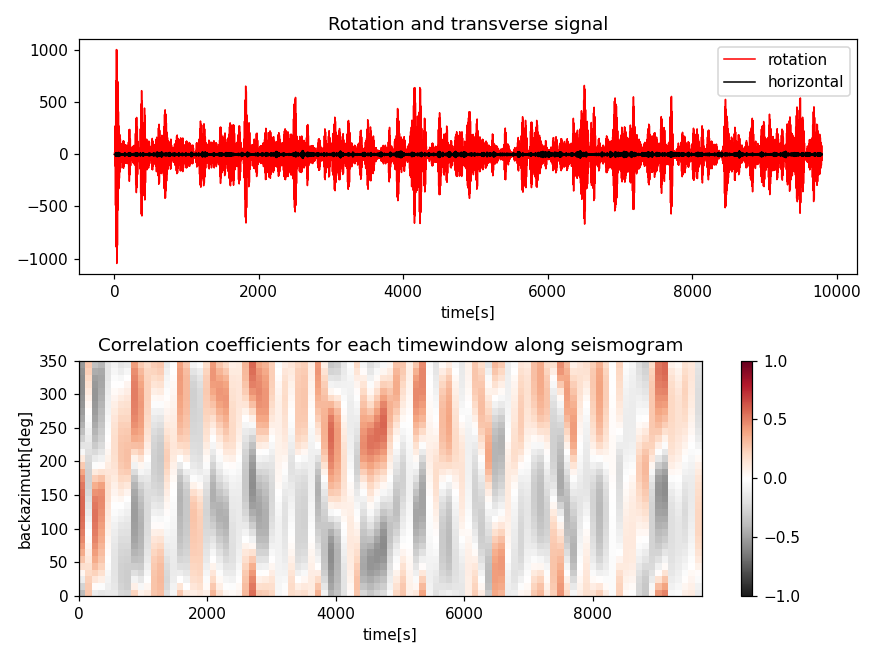

In [37]:
#Cell 3c:

plt.ioff()
# plot result
# this uses data fetched in Cell 3a and prepared in Cell 3b

# create time vector for the backazimuth plot (uses sliding timewindow lengths)
timevec = np.linspace(0,nwin*(lwin-dwin) + dwin, nwin)

plt.subplot(2,1,1)
plt.title('Rotation and transverse signal')
plt.plot(st_rl[0].times(), st_rl[0].data, 'r', label='rotation')
plt.plot(st_bb[0].times(), st_bb[0].data*.5e9, 'k', label='horizontal')
plt.xlabel('time[s]')
plt.legend()
plt.subplot(2,1,2)
plt.title('Correlation coefficients for each timewindow along seismogram')
plt.pcolormesh(timevec, BAZ, corr_zerolag, cmap='RdGy_r', vmin=-1, vmax=1)
plt.colorbar()
plt.xlabel('time[s]')
plt.ylabel('backazimuth[deg]')

plt.tight_layout()
plt.show()

**Answer:** ...